In [1]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import modsim.models.iq_modulator as iqm
from modsim.signal_gen.arbitrary_generator import SignalGen
%matplotlib inline

In [2]:
# instantiating signal generation
awg = SignalGen(num_of_samples = 256*1024, sampling_time = 25e-5, samples_per_symbol = 4)

In [19]:
# MZM settings
Ein = 1
Vpi_rf_I = 1
Vpi_rf_Q = Vpi_rf_I
Vpi_bias_I = np.sqrt(Vpi_rf_I)
Vpi_bias_Q = np.sqrt(Vpi_rf_I)
Vpi_bias_P = np.sqrt(Vpi_rf_I)
ER_model = 'Finite'
ER_dB_I = 20
ER_dB_Q = 20
ER_dB_P = 100
heaters = True

# RF settings
pulse_fmt = 'NRZ'
Vpp_rf_I = 0.5 * Vpi_rf_I
Vpp_rf_Q = 0.5 * Vpi_rf_I
f_bw = None #1.5e3
f_ord = 2

# heater driving definitions
Vcc = 5
push_pull = False
pre_sqrt = True

# bias settings
bias_dc_I = 1.0 * Vpi_bias_I - (2 / np.pi) / np.sqrt(10 ** (ER_dB_Q / 10)) * Vpi_bias_I
bias_dc_Q = 1.0 * Vpi_bias_Q + (2 / np.pi) / np.sqrt(10 ** (ER_dB_I / 10)) * Vpi_bias_Q
bias_dc_P = 0.58 * Vpi_bias_P # (np.sqrt(2) / 2) # 0.5
Vpp_dither_I = 0.05 * Vpi_bias_I
Vpp_dither_Q = 0.05 * Vpi_bias_Q
Vpp_dither_P = 0.0 * Vpi_bias_P
f_dither_I = 3 #[Hz]
f_dither_Q = 5 #[Hz]
f_dither_P = 0 #[Hz]

# generating signals
Vrf_I = awg.pulse_sequence_gen(pulse_fmt, Vpp_rf_I / 2, f_bw = f_bw, f_order = f_ord) # [1 kbaud]
Vrf_Q = awg.pulse_sequence_gen(pulse_fmt, Vpp_rf_Q / 2, f_bw = f_bw, f_order = f_ord) # [1 kbaud]

Vbias_I = bias_dc_I + awg.waveform_gen(Vpp_dither_I / 2, f_dither_I, 0)
Vbias_Q = bias_dc_Q + awg.waveform_gen(Vpp_dither_Q / 2, f_dither_Q, 0)
Vbias_P = bias_dc_P + awg.waveform_gen(Vpp_dither_P / 2, f_dither_P, 0)
Vramp = 12 * np.linspace(-1, 1, len(awg.time))

# modulating RF and bias
if heaters:

    # heater driving definitions
    Vheat_I = Vbias_I
    Vheat_Q = Vbias_Q
    Vheat_P = Vbias_P

    # square-root before applying voltage
    if pre_sqrt:
        V_I = np.sqrt(Vheat_I)
        V_Q = np.sqrt(Vheat_Q)
        V_P = np.sqrt(Vheat_P)
        
    else:
        V_I = Vheat_I
        V_Q = Vheat_Q
        V_P = Vheat_P

    # single heater vs. dual drive push-pull
    if push_pull:                
        Vb_I_1 = (Vcc - V_I) / 2
        Vb_Q_1 = (Vcc - V_Q) / 2
        Vb_P_1 = (Vcc - V_P) / 2
        
        Vb_I_2 = V_I / 2
        Vb_Q_2 = V_Q / 2
        Vb_P_2 = V_P / 2
        
    else:            
        Vb_I_1 = V_I
        Vb_Q_1 = V_Q
        Vb_P_1 = V_P
        
        Vb_I_2 = 0
        Vb_Q_2 = 0
        Vb_P_2 = 0

    Vrf_I_1 = Vrf_I / 2
    Vrf_Q_1 = Vrf_Q / 2
    
    Vrf_I_2 = -Vrf_I / 2
    Vrf_Q_2 = -Vrf_Q / 2

    [Eout, EoutI, EoutQ] = iqm.lin_with_heaters(Ein,
                                 Vrf_I_1, Vrf_I_2,
                                 Vrf_Q_1, Vrf_Q_2,
                                 Vb_I_1, Vb_I_2,
                                 Vb_Q_1, Vb_Q_2,
                                 Vb_P_1, Vb_P_2,
                                 Vpi_rf_I = Vpi_rf_I,
                                 Vpi_rf_Q = Vpi_rf_Q,
                                 Vpi_bias_I = Vpi_bias_I,
                                 Vpi_bias_Q = Vpi_bias_Q,
                                 Vpi_bias_P = Vpi_bias_P,
                                 ER_model = ER_model, 
                                 ER_dB_I = ER_dB_I, 
                                 ER_dB_Q = ER_dB_Q,
                                 ER_dB_P = ER_dB_P,
                                 get_arms = True)
    
else:
    
    [Eout, EoutI, EoutQ] = iqm.linear(Ein,
                                 Vrf_I,
                                 Vrf_Q,
                                 Vbias_I,
                                 Vbias_Q,
                                 Vbias_P,
                                 Vpi_rf_I = Vpi_rf_I,
                                 Vpi_rf_Q = Vpi_rf_Q,
                                 Vpi_bias_I = Vpi_bias_I,
                                 Vpi_bias_Q = Vpi_bias_Q,
                                 Vpi_bias_P = Vpi_bias_P,
                                 ER_model = ER_model, 
                                 ER_dB_I = ER_dB_I, 
                                 ER_dB_Q = ER_dB_Q,
                                 ER_dB_P = ER_dB_P,
                                 get_arms = True)

# PD power
Pout = np.abs(Eout) ** 2
PoutI = np.abs(EoutI) ** 2
PoutQ = np.abs(EoutQ) ** 2

# PD spectrum
Pout_f = np.fft.fftshift(np.fft.fft(Pout))
PoutI_f = np.fft.fftshift(np.fft.fft(PoutI))
PoutQ_f = np.fft.fftshift(np.fft.fft(PoutQ))

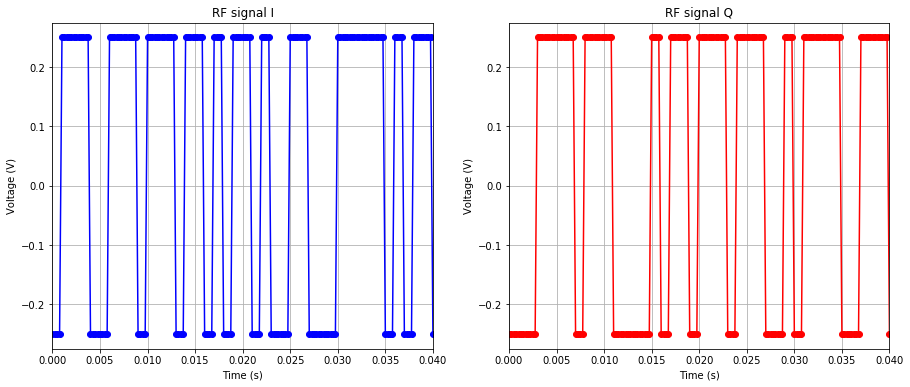

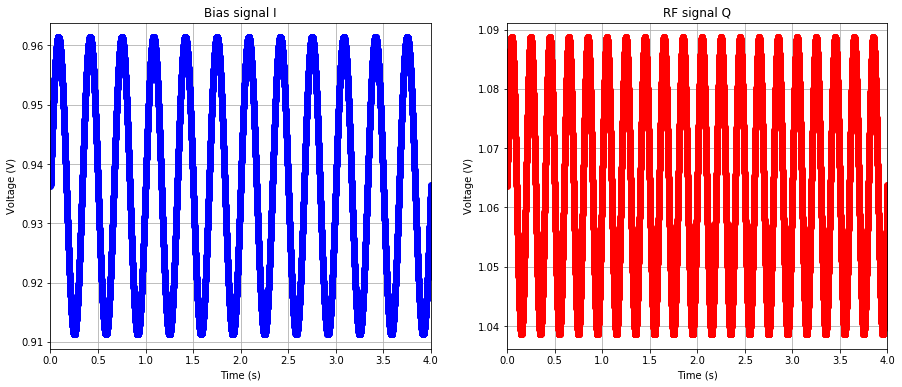

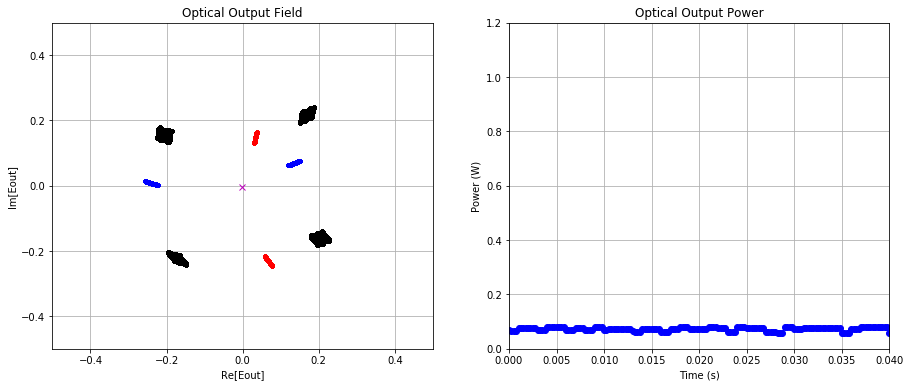

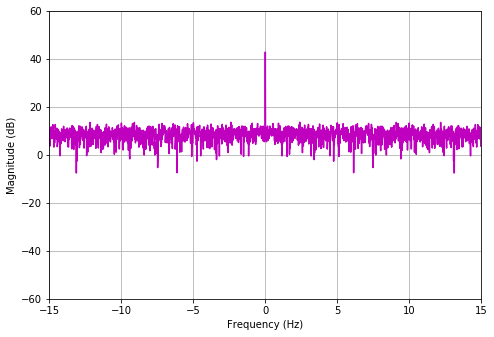

In [21]:
# plotting RF

fig1, axes1 = plt.subplots(1, 2, figsize = (15, 6))

axes1[0].plot(awg.time, Vrf_I, 'bo-')
axes1[0].set_xlabel('Time (s)')
axes1[0].set_ylabel('Voltage (V)')
axes1[0].set_xlim(0, 4e-2)
axes1[0].set_title('RF signal I')
axes1[0].grid('on')

axes1[1].plot(awg.time, Vrf_Q, 'ro-')
axes1[1].set_xlabel('Time (s)')
axes1[1].set_ylabel('Voltage (V)')
axes1[1].set_xlim(0, 4e-2)
axes1[1].set_title('RF signal Q')
axes1[1].grid('on')

# plotting bias signals

fig2, axes2 = plt.subplots(1, 2, figsize = (15, 6))

axes2[0].plot(awg.time, Vbias_I, 'bo-')
axes2[0].set_xlabel('Time (s)')
axes2[0].set_ylabel('Voltage (V)')
axes2[0].set_xlim(0, 4)
axes2[0].set_title('Bias signal I')
axes2[0].grid('on')

axes2[1].plot(awg.time, Vbias_Q, 'ro-')
axes2[1].set_xlabel('Time (s)')
axes2[1].set_ylabel('Voltage (V)')
axes2[1].set_xlim(0, 4)
axes2[1].set_title('RF signal Q')
axes2[1].grid('on')

# plotting PD output

fig3, axes3 = plt.subplots(1, 2, figsize = (15, 6))

axes3[0].plot(np.real(Eout), np.imag(Eout), 'k.')
axes3[0].plot(np.real(EoutI), np.imag(EoutI), 'b.')
axes3[0].plot(np.real(EoutQ), np.imag(EoutQ), 'r.')
axes3[0].plot(np.real(np.mean(Eout)), np.imag(np.mean(Eout)), 'mx')
axes3[0].set_xlabel('Re[Eout]')
axes3[0].set_ylabel('Im[Eout]')
axes3[0].set_xlim(-0.5, 0.5)
axes3[0].set_ylim(-0.5, 0.5)
axes3[0].set_title('Optical Output Field')
axes3[0].grid('on')

axes3[1].plot(awg.time, Pout, 'bo-')
axes3[1].set_xlabel('Time (s)')
axes3[1].set_ylabel('Power (W)')
axes3[1].set_xlim(0, 4e-2)
axes3[1].set_ylim(0, 1.2)
axes3[1].set_title('Optical Output Power')
axes3[1].grid('on')


fig0 = plt.figure()
F0 = fig0.add_axes([0, 0, 1, 1])
F0.plot(awg.frequency, 10 * np.log10(abs(Pout_f)), 'm-')
F0.set_xlabel('Frequency (Hz)')
F0.set_ylabel('Magnitude (dB)')
F0.set_xlim([-15, 15])
F0.set_ylim([-60, 60])
F0.grid('on')


In [18]:
bias_dc_I

0.9363380227632419

In [ ]:
bias_dc_Q

In [ ]:
np.sqrt(2)/2